###  SPEECH RECOGNITION EXERCISES
###  DECISION TREE TRAINING
*Dirk Van Compernolle*   
*Last Revision: 10/12/19*

**GOAL:**
In this exercise you perform decision tree training for context-depedent models.
The idea is to create a collection of context-dependent allophonic models by which the 
likelihood of the training data is increased.

This codebook contains 2 similar exercises.
1.  Training of a tiny tree in which only two questions about left context are possible, generate 4 nodes at most
2.  Training of a small tree in which 4 questions can be asked both about left and right context.
Adjust minimum gain for a split or minimum occupancy of a node to control the growth of the tree.
Depending on the parameter settings you may end up with trees with 3 nodes / 2 leafs to 10 nodes / 6 leafs

##### WARNINGS
While the code setup is generic, it's main intent is didactically rather than 'production quality' 
- code is not optimized, as its main intent is readability
- e.g. more information is maintained in the nodes than necessary, but it allows for easier inspection
- limited to discrete densities
- question format: set membership (same questions in all positions)
- a greedy algorithm is used to grow the tree one depth level at a time 
  + there is no growth prioritization within a level or across levels
  
##### DEPENDENCIES
- *numpy, matplotlib*

In [1]:
try:
  import google.colab
  IN_COLAB = True
  ! pip install matplotlib==3.1.0
except:
  IN_COLAB = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
# Definition of the Distribution Class Objects
#
class _Dist():
    ''' 
    A generic object for a probability distribution 
    '''
    def __init__(self,tolerance=1.e-7):
        self.frozen = False
        self.tolerance = 1.e-7
        
class DiscreteDist(_Dist):
    '''
    The class DiscreteDist is a generic Discrete Density Object
    for N discrete variables.  Most functions work with discrete indices
    [0 .. N-1], optionally in some cases a set of labels (list of strings) may 
    be attributed to the indices
    
    Attributes:
        type        'Discrete'          
        prob        probability vector (N,_)
        counts      list holding counts
    
    Methods:
        pdf()       pdf() actually a probability mass function in the discrete case,
                    but is used to be consistent with  the continuous density classes
        plot()
        _check()
    
    See Also
        scipy.stats.rv_discrete()   prob[] is used similar to values[1,:]
    '''
    
    def __init__(self,prob=[],dim=2,labels=None):
        _Dist.__init__(self)
        self.type = 'Discrete'
        if(labels == None):
            self.dim=dim
            self.labels = np.arange(self.dim,dtype='int')
        else:
            self.labels = labels
        if len(prob)==0:            
            self.prob = np.ones(self.dim,dtype='float')/float(self.dim)
        self.indx = np.arange(self.dim,dtype='int')
        self.counts = np.zeros(self.dim,dtype='int')

        self._check()

    def pdf(self,x):
        return( self.prob[np.asarray(x)] )
    
    def logpdf(self,x):
        return( np.log(self.pdf(x)+self.tolerance) )

    def fit(self,x,reset=True):
        if(reset): self.counts.fill(0)
        for i in x:
            self.counts[i] += 1
        sum_of_counts = float(np.sum(self.counts))
        self.prob = self.counts.astype(float)/sum_of_counts
    
    def entropy(self,x):
        '''
        entropy measures
        - true entropy of distribution for x=[]
        - cross entropy of a sample x with respect to the measured distribution in self
        '''
        xx = np.asarray(x)
        Hx = 0.0       
        # compute entropy of discrete RV
        if xx.size == 0:
            logprob = np.log(self.prob + self.tolerance)
            for i in range(0,self.dim):
                Hx -= self.prob[i]*logprob[i]
            print(Hx)
        
        # else compute cross entry between samples x and estimated distribution
        else:    
            Hx = - np.sum(self.logpdf(xx)) / float(xx.size)
        return(Hx)
    
    def print(self):
        print("  MODEL - PROBS[%d] = " % self.dim,self.prob)

        
    def plot(self,labels=None,title=""):
        if labels != None:
            self.labels = labels
        fig,ax = plt.subplots(1,1)
        plt.plot(self.indx,self.prob,'ro',ms=10,mec='k')
        plt.vlines(self.indx,0,self.prob,colors='red',lw=5)
        plt.xticks(self.indx,self.labels)
        if title is "":
            title = 'Probability Mass Function'
        plt.title(title)
        
    def _check(self):
        sumprob = np.sum(self.prob)
        if(abs(sumprob -1.0) > self.tolerance):
            print('WARNING(DiscreteDist): Deviating Sum of Probabilities:    ', sumprob)
            print('WARNING(DiscreteDist): Renormalizing !! ')
            self.prob = self.prob / sumprob
        if(len(self.prob) != len(self.labels) ) :
            print( 'WARNING(DiscreteDist): Length of labels doesn\'t match length of probs')
            print( 'WARNING(DiscreteDist): Reverting to INTEGER INDICES as LABELS')
            self.indx = np.arange(len(prob),dtype='int')
            self.labels = self.indx
            self.labels = self.indx

In [4]:
# Definition of the node class objects (used to build decision trees)
#
class node():
    '''
    The class node() is an object that holds a node in a decision tree.
    
    Attributes:
        id          id of the node
        parent      parent id
        depth       depth in decision tree
        posquestion [position, question] : asked 'question' at 'position' to generate the children
        children    tuple holding the node id's of the children
        features    list (number of positions) of lists with context conditioning features
        n_features  number of context positions to be evaluated
        data_indx   list of indices of datapoints belong in the node
        n_samples   number of datapoints in node
        model       a distribution object
        ll          log likelihood for data in the node
        is_leaf     flag indicating is the node has been determined a leaf
        is_split    flag indicating that the node has been split and is non-terminal
    
    Methods:
        print()     print the contents of the node
        
        fit(X)      fit the data in X given the indices in the node
        
        split(X,Xfeatures,posquestion)
                    split the node for the given positional question

    '''
    
    def __init__(self,id=0,data_indx=[],parent=None,dim=2):
        self.id = id
        self.parent = parent
        self.depth = 0
        self.children = None
        self.data_indx = data_indx
        self.n_samples = len(data_indx)
        self.features = [[]]
        self.n_features = 0
        self.model = DiscreteDist(dim=dim)
        self.ll = None
        self.posquestion = None
        self.is_leaf = False
        self.is_split = False
     
    def print(self):
        print("+++ NODE: ",self.id,)
        print("+ FEATURES: ",self.features)
        print("+ SAMPLES: ",self.n_samples, self.data_indx)   
        print("+ DATA LIKELIHOOD:",self.ll,end='   ++')
        self.model.print()
        
    def fit(self,X):
        X_select = [X[i] for i in self.data_indx]
        self.model.fit(X_select)
        self.ll = np.sum(self.model.logpdf(X_select)) 
   
    # split node self into true/false children given a question and criteria thresholds
    def split(self,data,data_features,posquestion,sample_threshold=2,gain_threshold=1.0):
        if self.is_leaf:
            raise ValueError('SPLIT ERROR: node is already a leaf')
            return
        
        true_child = copy.deepcopy(self)
        false_child = copy.deepcopy(self)
        true_child.parent = self.id
        false_child.parent = self.id
        true_child.depth = self.depth + 1
        false_child.depth = self.depth + 1
        
        position = posquestion[0]
        question = posquestion[1]
        # split the data
        true_child.data_indx = []
        false_child.data_indx = []
        for i in self.data_indx:
            if( data_features[i][position] in question ):
                true_child.data_indx.append(i)
            else:
                false_child.data_indx.append(i)
        true_child.n_samples = len(true_child.data_indx)
        false_child.n_samples = len(false_child.data_indx)
        if min(true_child.n_samples,false_child.n_samples) < sample_threshold: 
            raise ValueError("SAMPLE Threshold NOT Passed (%d,%d)" % (true_child.n_samples,false_child.n_samples))
            return

        true_child.fit(data)
        false_child.fit(data)
        llgain = true_child.ll + false_child.ll - self.ll
        if llgain < gain_threshold:
            raise ValueError("GAIN Threshold NOT Exceeded (%.3f < %.3f)" %(llgain,gain_threshold))
            return
        
        true_child.features[position] = self.features[position].intersection(question)
        false_child.features[position] = self.features[position] - question
        
        return true_child,false_child,llgain   

In [5]:
# Definition of Decision Tree Object Class
#
class decision_tree():
    def __init__(self,X,features,question_list):
        self.nodes = []
        self.nodes.append( node(id=0,data_indx=[i for i in range(len(X))],dim=n_labels) )
        self.nodes[0].features = features
        self.nodes[0].n_features = len(features)
        self.nodes[0].parent = -1
        self.nodes[0].fit(X)
        self.n_nodes = 1
        self.start_test = 0
        self.features = features
        self.question_list = question_list
        self.print_level = 0
        
    def print(self):
        print("========   DECISION TREE   ============")
        print("n_nodes:%d"%self.n_nodes)
        for i in range(0,self.n_nodes):
            edge = tree.nodes[i].depth * "    "
            print("%snode(%d): samples=%d,  ll=%.2f, features="% 
                  (edge,i,self.nodes[i].n_samples,self.nodes[i].ll),
                  self.nodes[i].features)
            if(self.nodes[i].is_leaf):
                print("%s\tLeaf with model: "%edge,end="")
                self.nodes[i].model.print()
        print("========================================\n")
        
    # plots the root model and all the leafs    
    def model_plot(self,labels=[]):
        self.nodes[0].model.plot(title= "Model in the root")
        for i in range(1,self.n_nodes):
            if(self.nodes[i].is_leaf):
                self.nodes[i].model.plot(title = ("Model for Node(%d) with Features "%i , self.nodes[i].features))
        
        
    # train 1 extra depth level of the decision tree
    def train1(self,X,Xfeatures,plist=[0],qlist=[],gain_threshold=1.0,sample_threshold=2,max_nodes=1000):


        # generate position specific question list
        pqlist=[]    
        for p in plist:
            for q in qlist:
                pqlist.append([p,q])
        if(self.print_level > 0): print("Position-Question List:",pqlist)
            
        new = self.n_nodes            
        for i in range(self.start_test, self.n_nodes):
            if self.nodes[i].is_split or self.nodes[i].is_leaf:   continue
            best_llgain = gain_threshold
            node_can_split = False

            if(self.print_level > 0): print('=== Trying to Split node=%d' % i)  
            # 3. loop over all possible [postion,question] possibilities
            for ipq in range(len(pqlist)):
                try:
                    (true_child,false_child,llgain) = self.nodes[i].split(X,Xfeatures,pqlist[ipq],
                        sample_threshold=sample_threshold,gain_threshold=best_llgain)
                    if(self.print_level > 2):  true_child.print(), false_child.print()
                    if(self.print_level > 0): 
                        print('= Position-Question: ',pqlist[ipq],'   Split(%d,%d) ACCEPTED, Likelihood Gain:  %.3f' %  
                              (true_child.n_samples,false_child.n_samples,llgain) )
                    self.nodes[i].question = pqlist[ipq]
                    self.nodes[i].children = [new, new+1]
                    best_llgain = llgain
                    node_can_split = True                        
                except ValueError as err:
                    if(self.print_level > 0): print('= Position-Question: ',pqlist[ipq],'   Split REJECTED: ',err) 
        
            # terminate splitting for current node
            if node_can_split:
                true_child.id = new
                false_child.id = new+1
                self.nodes.append(true_child)
                self.nodes.append(false_child)
                if(self.print_level >= 0): 
                    print("=>> SPLITTING NODE(%d) with QUESTION " % i, self.nodes[i].question,
                      " SPLIT=(%d,%d), GAIN= %.2f" % (true_child.n_samples,false_child.n_samples,best_llgain) )
                new = new+2
                self.nodes[i].is_split = True
            else:
                if(self.print_level >= 0): print("=>> SPLITTING NODE(%d) UNSUCCESFULL, marked as leaf" %i)
                self.nodes[i].is_leaf = True
            if new > max_nodes: break

        # terminate for current depth
        self.start_test = self.n_nodes
        self.n_nodes = new       
    
    # should be called after last iteration level to mark all remaining nodes as leaves
    def terminate(self):
        for i in range(self.start_test,self.n_nodes):
            self.nodes[i].is_leaf = True

In [6]:
#### EXERCISE 1 ########
#### DATA ENTRY and some data preprocessing
#
# segmental data is given consisting of  [segment_id, [data_labels], [context] ]
#
segment_data = [
    ['IY', [1,2,3,3],   ['F','#'] ],
    ['IY', [1,2,2,1],   ['V','#'] ],
    ['IY', [4,4,4],     ['P','#'] ],
    ['IY', [3,4,4,3,4], ['T','#'] ],
    ['IY', [4,4,3,3],   ['D','#'] ],
    ['IY', [2,1,2,3],   ['S','#'] ],
    ['IY', [1,1,2,1],   ['TH','#']]
]
phones = {'F','V','P','T','D','S','TH','IY',"#"}
labels = [1,2,3,4]

# do some processing
# 1. The discretized datalabels [1,2,3,4] are mapped to python indices [0,1,2,3]
# 2. The data is flattened into a long array containing
# 3. The contexts are stored in a synchronized context array
n_labels = len(labels)
lbl2idx = dict(zip(labels, range(n_labels)))
idx2lbl = dict(zip(range(n_labels), labels))

X = []
Xfeatures = []
for i in range(len(segment_data)):
    idx = [lbl2idx[lbl] for lbl in segment_data[i][1] ]
    for k in idx:
        X.append(k)
        Xfeatures.append(segment_data[i][2]) 

#print( X, Xfeatures )

========   DECISION TREE   ============
n_nodes:1
node(0): samples=28,  ll=-38.67, features= [{'TH', 'D', 'V', 'F', 'P', 'T', 'S'}, {}]

Position-Question List: [[0, {'D', 'V'}], [0, {'D', 'P', 'T'}]]
=== Trying to Split node=0
= Position-Question:  [0, {'D', 'V'}]    Split REJECTED:  GAIN Threshold NOT Exceeded (0.058 < 0.500)
= Position-Question:  [0, {'D', 'P', 'T'}]    Split(12,16) ACCEPTED, Likelihood Gain:  14.341
=>> SPLITTING NODE(0) with QUESTION  [0, {'D', 'P', 'T'}]  SPLIT=(12,16), GAIN= 14.34
========   DECISION TREE   ============
n_nodes:3
node(0): samples=28,  ll=-38.67, features= [{'TH', 'D', 'V', 'F', 'P', 'T', 'S'}, {}]
    node(1): samples=12,  ll=-7.64, features= [{'D', 'P', 'T'}, {}]
    node(2): samples=16,  ll=-16.69, features= [{'F', 'V', 'S', 'TH'}, {}]

Position-Question List: [[0, {'D', 'V'}], [0, {'D', 'P', 'T'}]]
=== Trying to Split node=1
= Position-Question:  [0, {'D', 'V'}]    Split REJECTED:  GAIN Threshold NOT Exceeded (0.367 < 0.500)
= Position-Questi

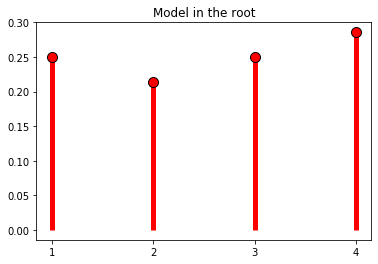

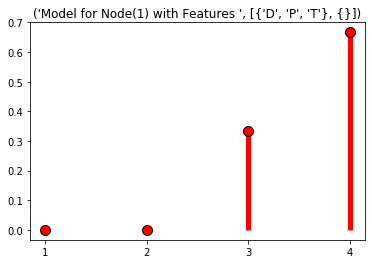

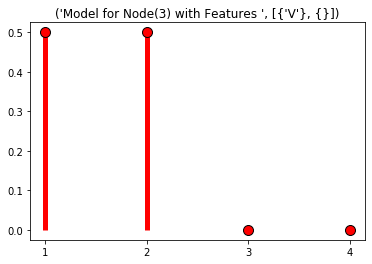

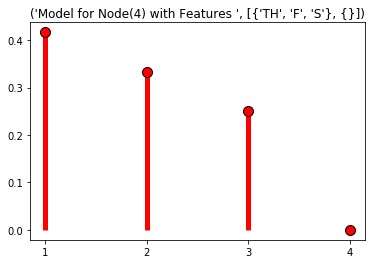

In [7]:
#### EXERCISE 1
#### DECISION TREE SETUP and TRAINING
#
question_list = [
  {'V','D'},       # VOICED
# {'S','TH'},      # FRICATIVES
 {'P','T','D'}    # PLOSIVES
]
# we only consider left_context questions
position_list = [0]
# set definitions of the features that we can questions about,
features = [ phones - {"#",'IY'}, {} ]        
# some decision tree parameters during training
gain_threshold = 0.5
sample_threshold = 3
#
# 1. initialize the tree and the root node
tree = decision_tree(X,features,question_list)
tree.nodes[0].model.labels = labels
tree.print()
# change the print_level to get more or less detailed output
tree.print_level = 1
# 2. train 1st level
tree.train1(X,Xfeatures,qlist=question_list,gain_threshold=gain_threshold,sample_threshold=sample_threshold)
tree.print()
# 3. train 2nd level
tree.train1(X,Xfeatures,qlist=question_list,gain_threshold=gain_threshold,sample_threshold=sample_threshold)
# 4. terminate (close all open nodes)
tree.terminate()
tree.print()
tree.model_plot()

In [8]:
#### EXERCISE 2
#### DATA
# segmental data is given consisting of  [segment_id, [data_labels], [context] ]
segment_data = [
    ['IY', [1,2,3,3],   ['F','#'] ],
    ['IY', [1,2,2,1],   ['V','K'] ],
    ['IY', [4,5,4],     ['P','T'] ],
    ['IY', [3,4,4,3,5], ['T','M'] ],
    ['IY', [4,4,3,3],   ['P','TH'] ],
    ['IY', [2,1,2,3],   ['S','S'] ],
    ['IY', [1,2,2,1],   ['V','K'] ],
    ['IY', [3,4,5,3,4], ['#','P'] ],
    ['IY', [3,4,4,5,5], ['#','N'] ],
    ['IY', [4,5,3,3],   ['P','TH'] ],
    ['IY', [2,1,2,3],   ['S','G'] ],
    ['IY', [1,1,2,1],   ['TH','S']]
]
labels = [1,2,3,4,5]
phones = {'F','V','P','T','D','S','TH','IY',"#","G","M","N"}

# do some processing
# 1. The discretized datalabels [1,2,3,4] are mapped to python indices [0,1,2,3]
# 2. The data is flattened into a long array containing
# 3. The contexts are stored in a synchronized context array
n_labels = len(labels)
lbl2idx = dict(zip(labels, range(n_labels)))
idx2lbl = dict(zip(range(n_labels), labels))

X = []
Xfeatures = []
for i in range(len(segment_data)):
    idx = [lbl2idx[lbl] for lbl in segment_data[i][1] ]
    for k in idx:
        X.append(k)
        Xfeatures.append(segment_data[i][2]) 

print( X, Xfeatures )

[0, 1, 2, 2, 0, 1, 1, 0, 3, 4, 3, 2, 3, 3, 2, 4, 3, 3, 2, 2, 1, 0, 1, 2, 0, 1, 1, 0, 2, 3, 4, 2, 3, 2, 3, 3, 4, 4, 3, 4, 2, 2, 1, 0, 1, 2, 0, 0, 1, 0] [['F', '#'], ['F', '#'], ['F', '#'], ['F', '#'], ['V', 'K'], ['V', 'K'], ['V', 'K'], ['V', 'K'], ['P', 'T'], ['P', 'T'], ['P', 'T'], ['T', 'M'], ['T', 'M'], ['T', 'M'], ['T', 'M'], ['T', 'M'], ['P', 'TH'], ['P', 'TH'], ['P', 'TH'], ['P', 'TH'], ['S', 'S'], ['S', 'S'], ['S', 'S'], ['S', 'S'], ['V', 'K'], ['V', 'K'], ['V', 'K'], ['V', 'K'], ['#', 'P'], ['#', 'P'], ['#', 'P'], ['#', 'P'], ['#', 'P'], ['#', 'N'], ['#', 'N'], ['#', 'N'], ['#', 'N'], ['#', 'N'], ['P', 'TH'], ['P', 'TH'], ['P', 'TH'], ['P', 'TH'], ['S', 'G'], ['S', 'G'], ['S', 'G'], ['S', 'G'], ['TH', 'S'], ['TH', 'S'], ['TH', 'S'], ['TH', 'S']]


========   DECISION TREE   ============
n_nodes:1
node(0): samples=50,  ll=-79.08, features= [{'G', 'N', 'TH', 'D', 'V', '#', 'IY', 'M', 'F', 'P', 'T', 'S'}, {'G', 'N', 'TH', 'D', 'V', '#', 'IY', 'M', 'F', 'P', 'T', 'S'}]

Position-Question List: [[0, {'D', 'G', 'V'}], [0, {'TH', 'S'}], [0, {'M', 'N'}], [0, {'D', 'P', 'T'}], [1, {'D', 'G', 'V'}], [1, {'TH', 'S'}], [1, {'M', 'N'}], [1, {'D', 'P', 'T'}]]
=== Trying to Split node=0
= Position-Question:  [0, {'D', 'G', 'V'}]    Split(8,42) ACCEPTED, Likelihood Gain:  8.523
= Position-Question:  [0, {'TH', 'S'}]    Split REJECTED:  GAIN Threshold NOT Exceeded (8.110 < 8.523)
= Position-Question:  [0, {'M', 'N'}]    Split REJECTED:  SAMPLE Threshold NOT Passed (0,50)
= Position-Question:  [0, {'D', 'P', 'T'}]    Split(16,34) ACCEPTED, Likelihood Gain:  11.002
= Position-Question:  [1, {'D', 'G', 'V'}]    Split REJECTED:  GAIN Threshold NOT Exceeded (2.158 < 11.002)
= Position-Question:  [1, {'TH', 'S'}]    Split REJECTED:  GAIN Threshold NOT

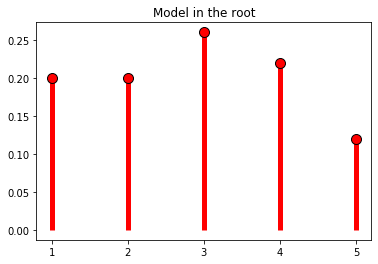

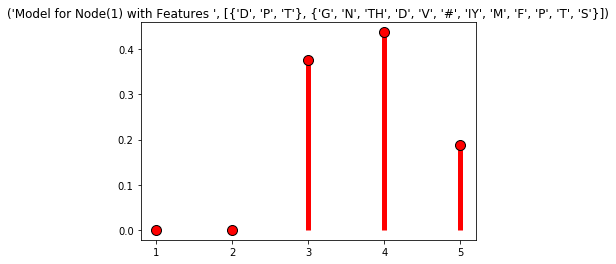

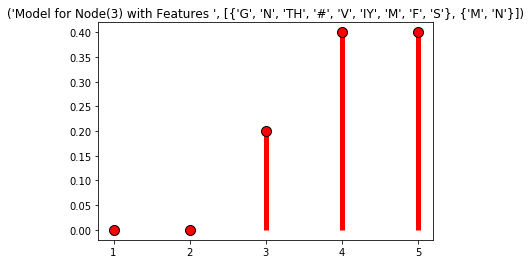

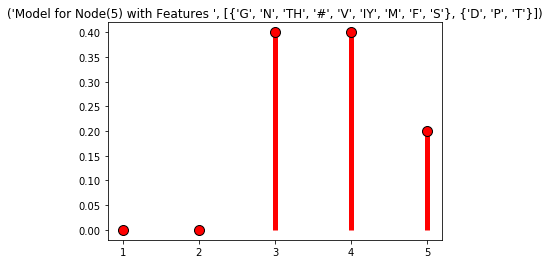

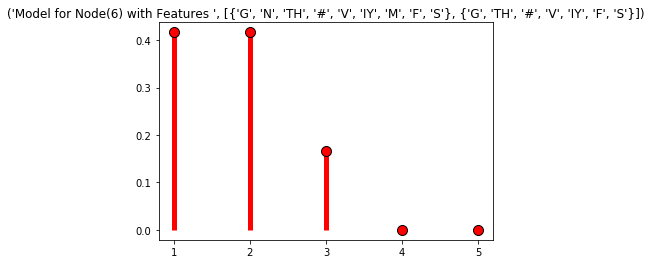

In [9]:
#### EXERCISE 2
#### DECISION TREE TRAINING

question_list = [
  {'V','D','G'},   # VOICED
  {'S','TH'},      # FRICATIVES
  {'M','N'},       # NASALS
  {'P','T','D'}    # PLOSIVES
]
# ask questions about positions 0 & 1, i.e. left and right context
position_list = [0,1]
# features that we can questions about in both left and right context
features = [ phones , phones ] 
# explore ranges 1.0 - 4.0
gain_threshold = 5.
# explore ranges 3 - 10
sample_threshold = 4
#
# 1. initialize the tree and the root node
tree = decision_tree(X,features,question_list)
tree.nodes[0].model.labels = labels
tree.print()
tree.print_level = 1
# 2. train 1st level
tree.train1(X,Xfeatures,plist=position_list,qlist=question_list,gain_threshold=gain_threshold,sample_threshold=sample_threshold)
tree.print()
# 3. train 2nd level
tree.train1(X,Xfeatures,plist=position_list,qlist=question_list,gain_threshold=gain_threshold,sample_threshold=sample_threshold)
# 4. train 3rd level
tree.train1(X,Xfeatures,plist=position_list,qlist=question_list,gain_threshold=gain_threshold,sample_threshold=sample_threshold)
# 5. train 4th level
tree.train1(X,Xfeatures,plist=position_list,qlist=question_list,gain_threshold=gain_threshold,sample_threshold=sample_threshold)
# 6. terminate (close all open nodes)
tree.terminate()
tree.print()
tree.model_plot()